# Руководство по использованию pandas для анализа больших наборов данных

Ссылка на материал: [Статья](https://habr.com/ru/company/ruvds/blog/442516/ "перейти на хабр")

In [36]:
import pandas as pd
try :
    df = pd.read_csv('../datasets/game_logs.csv', low_memory=False)
except:
    df = pd.read_csv('https://query.data.world/s/ocx5ikmouua2a3hbcuhtlql25xemb2', low_memory=False)

df.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,Sat,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,Mon,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,Tue,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


* date — Дата проведения игры.
* v_name — Название команды гостей.
* v_league — Лига команды гостей.
* h_name — Название команды хозяев.
* h_league — Лига команды хозяев.
* v_score — Очки команды гостей.
* h_score — Очки команды хозяев.
* v_line_score — Сводка по очкам команды гостей, например — 010000(10)00.
* h_line_score — Сводка по очкам команды хозяев, например — 010000(10)0X.
* park_id — Идентификатор поля, на котором проводилась игра.
* attendance — Количество зрителей.

По умолчанию pandas, ради экономии времени, указывает приблизительные сведения об использовании памяти объектом DataFrame. Нас интересуют точные сведения, поэтому мы установим параметр memory_usage в значение 'deep'.

In [37]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 859.5 MB


Так как данные разных типов хранятся раздельно, мы исследуем использование памяти разными типами данных. Начнём со среднего показателя использования памяти по разным типам данных.

In [38]:
for dtype in ['float','int','object']:
    selected_dtype = df.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 1.29 MB
Average memory usage for int columns: 1.12 MB
Average memory usage for object columns: 9.50 MB


Для проверки минимального и максимального значения, подходящего для хранения с использованием каждого целочисленного подтипа, можно воспользоваться методом numpy.iinfo(). Рассмотрим пример:

In [39]:
import numpy as np
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



## Оптимизация хранения числовых данных с использованием подтипов

Функцию pd.to_numeric() можно использовать для нисходящего преобразования числовых типов. Для выбора целочисленных столбцов воспользуемся методом DataFrame.select_dtypes(), затем оптимизируем их и сравним использование памяти до и после оптимизации.

In [40]:
# Мы будем часто выяснять то, сколько памяти используется,
# поэтому создадим функцию, которая поможет нам сэкономить немного времени.


def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

df_int = df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

7.87 MB
1.48 MB


,before,after
uint8,NaN,5.0
uint32,NaN,1.0
int64,6.0,NaN


Сделаем то же самое со столбцами, содержащими числа с плавающей точкой.

In [41]:
df_float = df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

100.99 MB
50.49 MB


,before,after
float32,NaN,77.0
float64,77.0,NaN


Создадим копию исходного объекта DataFrame, используем эти оптимизированные числовые столбцы вместо тех, что присутствовали в нём изначально, и посмотрим на общий показатель использования памяти после оптимизации.

In [42]:
optimized_df = df.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(df))
print(mem_usage(optimized_df))

859.45 MB
802.57 MB


Хотя мы значительно уменьшили потребление памяти столбцами, хранящими числовые данные, в целом, по всему объекту DataFrame, потребление памяти снизилось лишь на 7%. Источником куда более серьёзного улучшения ситуации может стать оптимизация хранения объектных типов.

## Сравнение механизмов хранения чисел и строк

Тип object представляет значения с использованием строковых объектов Python. Отчасти это так от того, что NumPy не поддерживает представление отсутствующих строковых значений. Так как Python — это высокоуровневый интерпретируемый язык, он не даёт программисту инструментов для тонкого управления тем, как данные хранятся в памяти.

Итак, сначала исследуем обычные строки:

In [43]:
from sys import getsizeof

s1 = 'working out'
s2 = 'memory usage for'
s3 = 'strings in python is fun!'
s4 = 'strings in python is fun!'

for s in [s1, s2, s3, s4]:
    print(getsizeof(s))

60
65
74
74


Теперь посмотрим на то, как выглядит использование строк в объекте Series:

In [44]:
obj_series = pd.Series(['working out',
                          'memory usage for',
                          'strings in python is fun!',
                          'strings in python is fun!'])
obj_series.apply(getsizeof)

0    60
1    65
2    74
3    74
dtype: int64

Тут можно видеть, что размеры строк, хранящихся в объектах Series pandas, аналогичны их размерам при работе с ними в Python и при представлении их в виде самостоятельных сущностей.

## Оптимизация хранения данных объектных типов с использованием категориальных переменных

Для того чтобы понять, где именно мы сможем воспользоваться категориальными данными для снижения потребления памяти, выясним количество уникальных значений в столбцах, хранящих значения объектных типов:

In [45]:
df_obj = df.select_dtypes(include=['object']).copy()
df_obj.describe()

,day_of_week,v_name,v_league,h_name,h_league,day_night,completion,forefeit,protest,park_id,...,h_player_6_id,h_player_6_name,h_player_7_id,h_player_7_name,h_player_8_id,h_player_8_name,h_player_9_id,h_player_9_name,additional_info,acquisition_info
count,171907,171907,171907,171907,171907,140150,116,145,180,171907,...,140838,140838,140838,140838,140838,140838,140838,140838,1456,140841
unique,7,148,7,148,7,2,116,3,5,245,...,4774,4720,5253,5197,4760,4710,5193,5142,332,1
top,Sat,CHN,NL,CHN,NL,D,"19200904,,0,6,36",H,V,STL07,...,grimc101,Charlie Grimm,grimc101,Charlie Grimm,lopea102,Al Lopez,spahw101,Warren Spahn,HTBF,Y
freq,28891,8870,88866,9024,88867,82724,1,69,90,7022,...,427,427,491,491,676,676,339,339,1112,140841


In [46]:
dow = df_obj.day_of_week
print(dow.head())

dow_cat = dow.astype('category')
print(dow_cat.head())

0    Thu
1    Fri
2    Sat
3    Mon
4    Tue
Name: day_of_week, dtype: object
0    Thu
1    Fri
2    Sat
3    Mon
4    Tue
Name: day_of_week, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']


Как видите, хотя тип столбца изменился, данные, хранящиеся в нём, выглядят так же, как и раньше. Посмотрим теперь на то, что происходит внутри программы.

В следующем коде мы используем атрибут Series.cat.codes для того, чтобы выяснить то, какие целочисленные значения тип category использует для представления каждого из дней недели:

In [47]:
dow_cat.head().cat.codes

0    4
1    0
2    2
3    1
4    5
dtype: int8

Теперь давайте сравним потребление памяти до и после преобразования столбца day_of_week к типу category.

In [48]:
print(mem_usage(dow))
print(mem_usage(dow_cat))

9.84 MB
0.16 MB


Создадим цикл, который перебирает все столбцы, хранящие данные типа object, выясняет, не превышает ли число уникальных значений в столбцах 50%, и если это так, преобразует их в тип category.

In [49]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]

Теперь сравним то, что получилось после оптимизации, с тем, что было раньше:

In [50]:
print(mem_usage(df_obj))
print(mem_usage(converted_obj))

compare_obj = pd.concat([df_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

750.60 MB
49.88 MB


,before,after
object,78.0,NaN
category,NaN,2.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
...,...,...
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0


Как видно, объём памяти, необходимый для работы со столбцами, хранящими данные типа object, снизился с 752 мегабайт до 52 мегабайт, то есть на 93%. Теперь давайте посмотрим на то, как нам удалось оптимизировать потребление памяти по всему набору данных. Проанализируем то, на какой уровень использования памяти мы вышли, если сравнить то, что получилось, с исходным показателем в 891 мегабайт.

In [51]:
optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'101.85 MB'

Результат впечатляет. Но мы ещё можем кое-что улучшить. Как было показано выше, в нашей таблице имеются данные типа datetime, столбец, хранящий которые, можно использовать в качестве первого столбца набора данных.

In [52]:
date = optimized_df.date
print(mem_usage(date))
date.head()

0.66 MB


0    18710504
1    18710505
2    18710506
3    18710508
4    18710509
Name: date, dtype: uint32

Можно вспомнить, что исходные данные были представлены в целочисленном виде и уже оптимизированы с использованием типа uint32. Из-за этого преобразование этих данных в тип datetime приведёт к удвоению потребления памяти, так как этот тип использует для хранения данных 64 бита. Однако в преобразовании данных к типу datetime, всё равно, есть смысл, так как это позволит нам легче выполнять анализ временных рядов.

Преобразование выполняется с использованием функции to_datetime(), параметр format которой указывает на то, что данные хранятся в формате YYYY-MM-DD.

In [53]:
optimized_df['date'] = pd.to_datetime(date,format='%Y%m%d')

print(mem_usage(optimized_df))
optimized_df.date.head()

102.51 MB


0   1871-05-04
1   1871-05-05
2   1871-05-06
3   1871-05-08
4   1871-05-09
Name: date, dtype: datetime64[ns]

## Выбор типов при загрузке данных

До сих пор мы исследовали способы уменьшения потребления памяти существующим объектом DataFrame. Мы сначала считывали данные в их исходном виде, затем, пошагово, занимались их оптимизацией, сравнивая то, что получилось, с тем, что было. Это позволило как следует разобраться с тем, чего можно ожидать от тех или иных оптимизаций. Как уже было сказано, часто для представления всех значений, входящих в некий набор данных, может попросту не хватить памяти. В связи с этим возникает вопрос о том, как применить методики экономии памяти в том случае, если нельзя даже создать объект DataFrame, который предполагается оптимизировать.

К счастью, оптимальные типы данных для отдельных столбцов можно указать ещё до фактической загрузки данных. Функция pandas.read_csv() имеет несколько параметров, позволяющих это сделать. Так, параметр dtype принимает словарь, в котором присутствуют, в виде ключей, строковые имена столбцов, и в виде значений — типы NumPy.

Для того чтобы воспользоваться этой методикой, мы сохраним итоговые типы всех столбцов в словаре с ключами, представленными именами столбцов. Но для начала уберём столбец с датой проведения игры, так как его нужно обрабатывать отдельно.

In [54]:
dtypes = optimized_df.drop('date',axis=1).dtypes

dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]

column_types = dict(zip(dtypes_col, dtypes_type))

# вместо вывода всех 161 элементов, мы
# возьмём 10 пар ключ/значение из словаря
# и аккуратно их выведем

preview = first2pairs = {key:value for key,value in list(column_types.items())[:10]}

In [55]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(preview)
#Вот что у нас получится:
{   'acquisition_info': 'category',
    'h_caught_stealing': 'float32',
    'h_player_1_name': 'category',
    'h_player_9_name': 'category',
    'v_assists': 'float32',
    'v_first_catcher_interference': 'float32',
    'v_grounded_into_double': 'float32',
    'v_player_1_id': 'category',
    'v_player_3_id': 'category',
    'v_player_5_id': 'category'}

{   'day_of_week': 'category',
    'h_game_number': 'uint8',
    'h_league': 'category',
    'h_name': 'category',
    'h_score': 'uint8',
    'number_of_game': 'uint8',
    'v_game_number': 'uint8',
    'v_league': 'category',
    'v_name': 'category',
    'v_score': 'uint8'}


{'acquisition_info': 'category',
 'h_caught_stealing': 'float32',
 'h_player_1_name': 'category',
 'h_player_9_name': 'category',
 'v_assists': 'float32',
 'v_first_catcher_interference': 'float32',
 'v_grounded_into_double': 'float32',
 'v_player_1_id': 'category',
 'v_player_3_id': 'category',
 'v_player_5_id': 'category'}

Теперь мы сможем воспользоваться этим словарём вместе с несколькими параметрами, касающимися данных о датах проведения игр, в ходе загрузки данных.

Соответствующий код получается довольно-таки компактным:

In [57]:
try :
    read_and_optimized = pd.read_csv('../datasets/game_logs.csv', dtype=column_types,parse_dates=['date'], infer_datetime_format=True)
except:
    read_and_optimized = pd.read_csv('https://query.data.world/s/ocx5ikmouua2a3hbcuhtlql25xemb2', dtype=column_types,parse_dates=['date'], infer_datetime_format=True)

print(mem_usage(read_and_optimized))
read_and_optimized.head()

102.51 MB


,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,1871-05-04,0,Thu,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,1871-05-05,0,Fri,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,1871-05-06,0,Sat,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,1871-05-08,0,Mon,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,1871-05-09,0,Tue,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


Данные теперь выглядят так, как показано на листе Фрагмент оптимизированного набора данных в этой таблице.

Внешне таблицы, приведённые на листах Фрагмент оптимизированного набора данных и Фрагмент исходного набора данных, за исключением столбца с датами, выглядят одинаково, но это касается лишь их внешнего вида. Благодаря оптимизации использования памяти в pandas нам удалось снизить потребление памяти с 861.6 Мбайт до 104.28 Мбайт, получив впечатляющий результат экономии 88% памяти.

# Анализ бейсбольных матчей

Теперь, после того, как мы оптимизировали данные, мы можем заняться их анализом. Взглянем на распределение игровых дней.

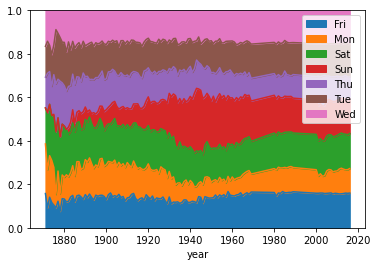

In [58]:
import matplotlib.pyplot as plt

optimized_df['year'] = optimized_df.date.dt.year
games_per_day = optimized_df.pivot_table(index='year',columns='day_of_week',values='date',aggfunc=len)
games_per_day = games_per_day.divide(games_per_day.sum(axis=1),axis=0)

ax = games_per_day.plot(kind='area',stacked='true')
ax.legend(loc='upper right')
ax.set_ylim(0,1)
plt.show()

Как видно, до 1920-х годов игры редко проводились по воскресеньям, после чего, примерно в течение 50 лет, игры в этот день постепенно проводились всё чаще.

Кроме того, можно заметить, что распределение дней недели, в которые проводились игры последние 50 лет, является практически неизменным.

Теперь взглянем на то, как со временем менялась длительность игр.

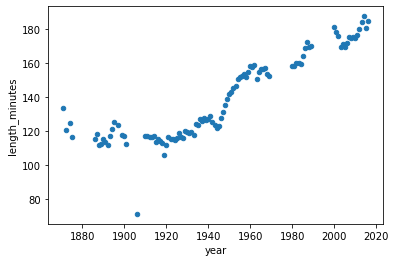

In [59]:
game_lengths = optimized_df.pivot_table(index='year', values='length_minutes')
game_lengths.reset_index().plot.scatter('year','length_minutes')
plt.show()

Возникает такое ощущение, что с 1940-х годов по настоящее время матчи становятся всё более длительными.

# Итоги

### В этом материале мы обсудили особенности хранения данных разных типов в pandas, после чего воспользовались полученными знаниями для уменьшения объёма памяти, необходимого для хранения объекта DataFrame, почти на 90%. Для этого мы применили две простые методики:

* Мы произвели нисходящее преобразование типов числовых данных, хранящихся в столбцах, выбрав более эффективные, в плане использования памяти, типы.
* Мы преобразовали строковые данные к категориальному типу данных.

Нельзя сказать, что оптимизация любого набора данных способна привести к столь же впечатляющим результатам, но, особенно учитывая возможность выполнения оптимизации на этапе загрузки данных, можно говорить о том, что любому, кто занимается анализом данных с помощью pandas, полезно владеть методиками работы, которые мы здесь обсудили.